# Basic convolutional network for MNIST classification tutorial

## Libraries

First we will load some libraries. We will need **Flux** *(obviously)*, from which we import the MNIST dataset, our loss function and tools for onehot encoding the labels and creating minibatches. We will also use **Statistics** for calculating accuracy.

In [1]:
using Flux
using Flux: Data.DataLoader
using Flux: onehotbatch, onecold, crossentropy
using Statistics
using MLDatasets

## Loading and transforming dataset

Now we will import the MNIST dataset.

In [12]:
x_train, y_train = MLDatasets.MNIST.traindata()
x_valid, y_valid = MLDatasets.MNIST.testdata();

In [13]:
x_train = Flux.unsqueeze(x_train, 3)
x_valid = Flux.unsqueeze(x_valid, 3);

Then we will onehot encode our training and test labels

In [14]:
y_train = onehotbatch(y_train, 0:9)
y_valid = onehotbatch(y_valid, 0:9);

And finally we will use DataLoader to manage minibatches. Here I've chosen a batchsize of 128 images.

In [15]:
train_data = DataLoader(x_train, y_train, batchsize=128);

## Creating the model

Now it is time to create our model. We will use **Chain()** and put our chosen layers there. You can chcek the full list of avilable layers [here](https://fluxml.ai/Flux.jl/stable/models/layers/).

But first lets define layers manually and see exactly what outputs they produce. First 4 layers are no mystery. We start with a convolution kernel 5x5 and we go from 1 channel to 8. Nest 3 layers are similar but with a kernel of 3x3. Then we do a GlobalMeanPool. This layer will take a mean from our 32 feature maps in each sample and return a vetor of 32 for each sample. But we can't feed it into thed ense layer yet becouse the dimentions won't mach. That is why we define layer 55 *(5.5)* which will simply drop the first 2 dimentions and produce a tensor of size 32xN. You can see it in the for loop.

In [21]:
layer1 = Conv((5, 5), 1=>8, pad=2, stride=2, relu) # Conv layer with a kernel of size 5x5, skipping every second pixel
layer2 = Conv((3, 3), 8=>16, pad=1, stride=2, relu)
layer3 = Conv((3, 3), 16=>32, pad=1, stride=2, relu)
layer4 = Conv((3, 3), 32=>32, pad=1, stride=2, relu)

layer5 = GlobalMeanPool() # Layer to take average from our 2x2 feature map

#layer55 = x -> reshape(x, :, size(x, 4)) # Layer to drop 2 first singleton dimentions
layer55 = flatten # The same thing as above but prettier

layer6 = Dense(32, 10) # Standard Linear layer
layer7 = softmax

layer8 = onecold; # Reverse onehot encoding and get a vector with predictions

In [22]:
layers = [layer1, layer2, layer3, layer4, layer5, layer55, layer6, layer7, layer8]
x = x_valid

for layer in layers
    println("Input size to layer: $layer = $(size(x))")
    x = layer(x)
    println("Output size from layer: $layer = $(size(x))\n")
end

Input size to layer: Conv((5, 5), 1=>8, relu) = (28, 28, 1, 10000)
Output size from layer: Conv((5, 5), 1=>8, relu) = (14, 14, 8, 10000)

Input size to layer: Conv((3, 3), 8=>16, relu) = (14, 14, 8, 10000)
Output size from layer: Conv((3, 3), 8=>16, relu) = (7, 7, 16, 10000)

Input size to layer: Conv((3, 3), 16=>32, relu) = (7, 7, 16, 10000)
Output size from layer: Conv((3, 3), 16=>32, relu) = (4, 4, 32, 10000)

Input size to layer: Conv((3, 3), 32=>32, relu) = (4, 4, 32, 10000)
Output size from layer: Conv((3, 3), 32=>32, relu) = (2, 2, 32, 10000)

Input size to layer: GlobalMeanPool() = (2, 2, 32, 10000)
Output size from layer: GlobalMeanPool() = (1, 1, 32, 10000)

Input size to layer: flatten = (1, 1, 32, 10000)
Output size from layer: flatten = (32, 10000)

Input size to layer: Dense(32, 10) = (32, 10000)
Output size from layer: Dense(32, 10) = (10, 10000)

Input size to layer: softmax = (10, 10000)
Output size from layer: softmax = (10, 10000)

Input size to layer: onecold = (10,

In [26]:
model = Chain(
    Conv((5, 5), 1=>8, pad=2, stride=2, relu), # 28x28 => 14x14
    Conv((3, 3), 8=>16, pad=1, stride=2, relu), # 14x14 => 7x7
    Conv((3, 3), 16=>32, pad=1, stride=2, relu), # 7x7 => 4x4
    Conv((3, 3), 32=>32, pad=1, stride=2, relu), # 4x4 => 2x2
    
    GlobalMeanPool(), # Average pooling on each width x height feature map

    #x -> reshape(x, :, size(x, 4)), # old way
    flatten,
    
    Dense(32, 10),
    softmax);

In [27]:
ŷ = model(x_train) # Getting predictions 
ŷ = onecold(ŷ) # Decoding predictions
println("Prediction of first image: $(ŷ[1])")

Prediction of first image: 5


We see  the model works but we haven't done any training yet so most likely it won't win any kaggle competitions just yet.

Now it is time to define our loss function, metric and optimizer. We will use a simple accuracy metrix, that is a mean of exact maches of the model predictions and labels. The loss function will be the standard in classification problems so crossentropy and we will use gradient descent as the optimizer. There are better choices but we will focus on the basics.

In [28]:
accuracy(ŷ, y) = mean(onecold(ŷ) .== onecold(y))

accuracy (generic function with 1 method)

In [29]:
loss(x, y) = Flux.crossentropy(model(x), y)

loss (generic function with 1 method)

In [30]:
lr = 0.1 # learning rate
opt = Descent(lr)

Descent(0.1)

In Flux we also have to take the parameters before training as we will pass them as an argument. Fortunately Flux has a function for that

In [32]:
ps = Flux.params(model);

Now that we have everything we will start training our model. The simplest way to do so is to call `train!` function provided in Flux. This will do a 1 full pass with forward and backward step.

In [34]:
Flux.train!(loss, ps, train_data, opt)

In [35]:
accuracy(model(x_train), y_train)

0.8872333333333333

If we want to specify the number of epochs we can do so by using the `@epochs` macro

In [37]:
using Flux: @epochs
number_epochs = 2

@epochs number_epochs Flux.train!(loss, ps, train_data, opt)

┌ Info: Epoch 1
└ @ Main C:\Users\arjur\.julia\packages\Flux\Fj3bt\src\optimise\train.jl:121
┌ Info: Epoch 2
└ @ Main C:\Users\arjur\.julia\packages\Flux\Fj3bt\src\optimise\train.jl:121


In [38]:
accuracy(model(x_train), y_train)

0.9542166666666667

Flux provides the option for callbacks in `train!` too. To do so we first define a function and the pass it to `train!` as the `cb` parameter. For example we will create a callback to show our loss while training. Callbacks are by default called with every batch of the data. We can change that with the `throttle` function from Flux which prevents the callback from beeing called for a specified number of seconds after the previous one. By using the `@show` macro it also prints the function.

In [190]:
callback() = push!(loss_vector, loss(x_train, y_train))
loss_vector = Vector{Float64}()

0-element Array{Float32,1}

In [71]:
Flux.train!(loss, ps, train_data, opt, cb=callback)

This way we could make a plot on how our loss changes while training. But here our callback makes predictions on all the training data on each batch so It's not the most efficient way for the long run.

It would be better to look at our loss on each epoch. For that we will create a custom training loop.

First lets recreate the `train!` function *(to some extent that is)*. For that we create a simple for loop over our DataLoader. Then we take the gradients and update our model. SImple as that! And thanks to Julia we aren't slaped with the performace penalty.

In [196]:
for batch in train_data
    
    gradient = Flux.gradient(ps) do
      training_loss = loss(batch...) # Remember that inside the loss() is the model
      return training_loss
    end
    
    Flux.update!(opt, ps, gradient)
end

Now lets put it in another loop for epochs and log the loss after each one of them.

In [204]:
epochs = 10
epochs_loss_list = Vector{Float64}()

for epoch in 1:epochs
    for batch in train_data
    
        gradient = Flux.gradient(ps) do
          training_loss = loss(batch...)
          return training_loss
        end

        Flux.update!(opt, ps, gradient)
    end
    
    push!(epochs_loss_list, loss(x_train, y_train))
end

In [205]:
epochs_loss_list

2-element Array{Float64,1}:
 0.07518023997545242
 0.07117365300655365

And we can finally plot it

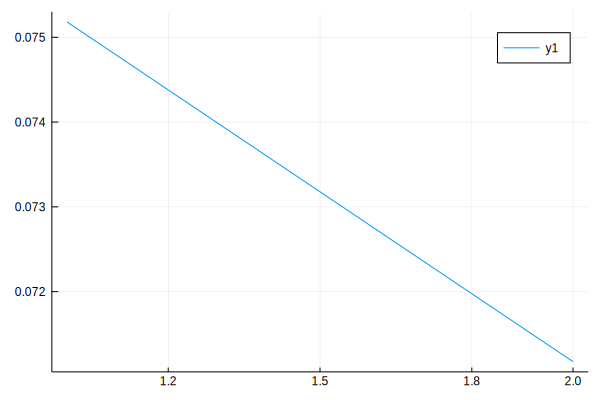

In [207]:
using Plots
plot(1:epochs, epochs_loss_list)

Now lets update the plot as we got through our epochs!

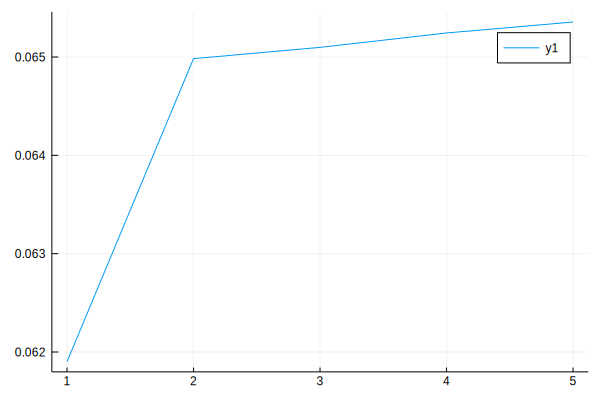

In [250]:
epochs = 10
epochs_loss_list = Vector{Float64}()

for epoch in 1:epochs
    for batch in train_data
    
        gradient = Flux.gradient(ps) do
          training_loss = loss(batch...)
          return training_loss
        end

        Flux.update!(opt, ps, gradient)
    end
    
    push!(epochs_loss_list, loss(x_train, y_train))
    IJulia.clear_output(true) #This will clear the output before plotting next epoch.
    display(plot(1:epoch, epochs_loss_list, legend=false))
end

In [258]:
accuracy(model(x_train), y_train)

0.9792666666666666